# Monte Carlo volume estimation

This notebook is split into three sections: 

Section 1 loads the data

Section 2 performs an area times volume estimate (Equation 1)

Section 3 performs a grade based volume estimate using the estimated Permian GRV (Equation 2)


## 1. Load data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 14})

df = pd.read_csv("BasaltData.csv")
Igz = df["Total igneous thickness"].dropna()
Well = df["Abbreviation"].dropna()
nlava = df["nLava"].dropna()
grade = df["Grade"].dropna()

alava = (Igz/nlava).dropna() # average lava thickness

area = np.array([2.157e11,2.09261e11,2.13958e11,2.13958e11,2.1393e11]) # area estimates to define normal distribution
vols = np.array([2.70265e14,2.02056e14,2.35955e14,2.35955e14,2.35905e14]) # volume estimates to define normal distribution

## 2. Area times volume (Equation 1):

In [2]:
# Input distributions:

sav, lav, scav = st.lognorm.fit(alava) # lava thickness
snv, lnv = st.expon.fit(nlava) # lava number
siga, mua = st.norm.fit(area) # area

# Fraction of cumulates:
fractionation = 55 # in % - alter this for desired cumulate percentage/fractionation
cum_frac = 1/(1-(fractionation*0.01)) # estimate multiplier for hidden volumes

randomstate = 314159
simulations = 100000

nlavas = []
zlavas = []
zBasalt = []
LIParea = []
simvols = []

np.random.seed(randomstate)

for i in range(simulations):
    nlav = st.expon.rvs(snv,lnv, size=1)
    nlavas.append(nlav)
    zlav = st.lognorm.rvs(sav, lav, scav, size=1)
    zlavas.append(zlav)
    zBas = nlav*zlav # number of lavas times avg thickness
    zBasalt.append(zBas)
    LIP = st.norm.rvs(siga, mua, size=1)
    LIParea.append(LIP)
    volb = LIP*zBas # total volume
    simvols.append(volb)
    
volsimus = np.asarray(simvols)
lavanumber = np.asarray(nlavas)
lavathickness = np.asarray(zlavas)
totalbasalt = np.asarray(zBasalt)
totalarea = np.asarray(LIParea)
lipvol = volsimus*cum_frac

results =pd.DataFrame(index=range(simulations), data={'Simulated Area': totalarea[:,0], 'Simulated Thickness': totalbasalt[:,0],'Lavas':lavanumber[:,0],'Lava Thickness (Avg)':lavathickness[:,0],  'Simulated Volume':volsimus[:,0], 'LIP Volume':lipvol[:,0]})
results.drop(results.loc[results['Lava Thickness (Avg)']>= 200.].index, inplace=True)
results.drop(results.loc[results['Lavas']< 0.].index, inplace=True)
results.describe(percentiles=[0.1,0.5,0.9])

,Simulated Area,Simulated Thickness,Lavas,Lava Thickness (Avg),Simulated Volume,LIP Volume
count,9.869100e+04,98691.000000,98691.000000,98691.000000,9.869100e+04,9.869100e+04
mean,2.133624e+11,114.410177,3.630603,31.504056,2.441211e+13,5.424914e+13
std,2.155676e+09,164.858041,2.631244,31.722869,3.517827e+13,7.817394e+13
min,2.033601e+11,0.911842,1.000004,0.805546,1.941352e+11,4.314116e+11
10%,2.106070e+11,13.930065,1.280030,6.025366,2.969289e+12,6.598420e+12
50%,2.133606e+11,60.099380,2.818970,20.569851,1.281776e+13,2.848392e+13
90%,2.161283e+11,266.013282,7.081771,72.052656,5.673318e+13,1.260737e+14
max,2.237009e+11,3455.505099,32.279886,199.936983,7.401830e+14,1.644851e+15


### Histograms:

This is Figure 6.A & 6.B in the manuscript

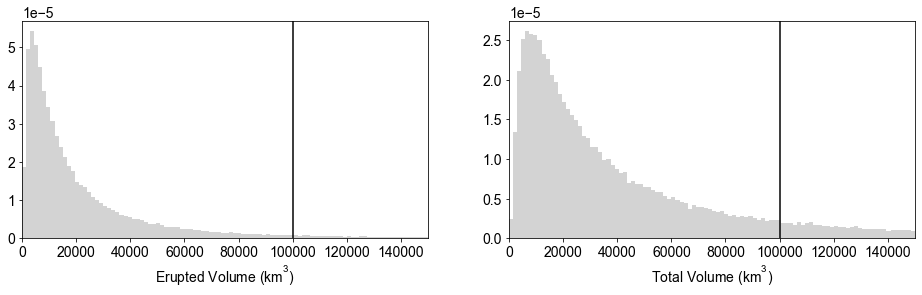

In [3]:
fig, (ax1,ax2)=plt.subplots(1,2, figsize=(16,4));
ax1.hist((volsimus/1e9), bins=100,range=(0, 1.5e5), density=True, color="lightgrey"); # convert to km3
ax1.set_xlim(0, 1.5e5);
ax1.axvline(1e5, c="k");
ax1.set_xlabel("Erupted Volume ($\mathregular{km^3}$)");
ax2.hist((lipvol/1e9), bins=100,range=(0, 1.5e5), density=True, color="lightgrey"); # convert to km3
ax2.set_xlim(0, 1.5e5);
ax2.set_xlabel("Total Volume ($\mathregular{km^3}$)");
ax2.axvline(1e5, c="k");

### Calculate probability of volume > LIP:

In [4]:
results['LIP'] = np.where(results['LIP Volume'] >= 1e14, 1, 0)
results['notLIP'] = np.where(results['LIP Volume'] <= 1e14, 1, 0)
pLIP = results[results["LIP Volume"] > 1e14].count()["LIP Volume"] / simulations
pBAS = results[results["Simulated Volume"] > 1e14].count()["Simulated Volume"] / simulations
print("Probability of LIP-volume exceedance for erupted basalt = ", pBAS)
print("Probability of LIP-volume exceedance for total volume = ", pLIP)

Probability of LIP-volume exceedance for erupted basalt =  0.03623
Probability of LIP-volume exceedance for total volume =  0.13926


## 3. GRV times basalt grade (Equation 2):

In [5]:
# Input distributions:

sigv, muv = st.norm.fit(vols)
distv = st.norm(loc=sigv, scale=muv)
shape, loc, scale = st.lognorm.fit(grade)

# Fraction of cumulates:
fractionation = 55 # in % - alter this for desired cumulate percentage/fractionation
cum_frac = 1/(1-(fractionation*0.01)) # estimate multiplier for hidden volumes

# initiate monte carlo
randomstate = 314159
simulations = 100000 

simvols = []
grvs = []
grades = []

np.random.seed(randomstate)

for i in range(simulations):
    vsim = st.norm.rvs(sigv, muv, size=1)
    gsim = st.lognorm.rvs(shape, loc, scale, size=1)
    volume = vsim*gsim
    simvols.append(volume)
    grvs.append(vsim)
    grades.append(gsim)
    
volsimus = np.asarray(simvols)
simgrade, simgrv = np.asarray(grades), np.asarray(grvs)
lipvol = volsimus*cum_frac

results =pd.DataFrame(index=range(simulations), data={'Simulated GRV': simgrv[:,0], 'Simulated Grade': simgrade[:,0], 'Simulated Volume':volsimus[:,0], 'LIP Volume':lipvol[:,0]})
results.drop(results.loc[results['Simulated Grade']>= 1.].index, inplace=True)
results.describe(percentiles=[0.1,0.5,0.9])

,Simulated GRV,Simulated Grade,Simulated Volume,LIP Volume
count,9.711900e+04,97119.000000,9.711900e+04,9.711900e+04
mean,2.359416e+14,0.123548,2.916113e+13,6.480250e+13
std,2.153311e+13,0.163763,3.893785e+13,8.652855e+13
min,1.537272e+14,0.007468,1.318610e+12,2.930243e+12
10%,2.083173e+14,0.014893,3.492717e+12,7.761593e+12
50%,2.358979e+14,0.058575,1.375992e+13,3.057759e+13
90%,2.636528e+14,0.321744,7.603349e+13,1.689633e+14
max,3.282577e+14,0.999569,2.848908e+14,6.330907e+14


### Histograms:

This is Figure 6.C & 6.D in the manuscript

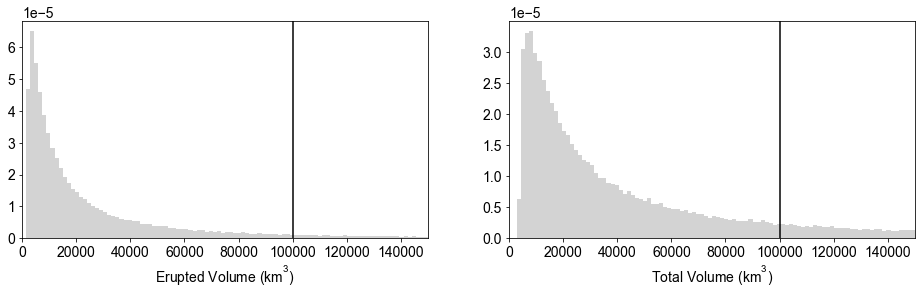

In [6]:
fig, (ax1,ax2)=plt.subplots(1,2, figsize=(16,4));
ax1.hist((volsimus/1e9), bins=100,range=(0, 1.5e5), density=True, color="lightgrey"); # convert to km3
ax1.set_xlim(0, 1.5e5);
ax1.axvline(1e5, c="k");
ax1.set_xlabel("Erupted Volume ($\mathregular{km^3}$)");
ax2.hist((lipvol/1e9), bins=100,range=(0, 1.5e5), density=True, color="lightgrey"); # convert to km3
ax2.set_xlim(0, 1.5e5);
ax2.set_xlabel("Total Volume ($\mathregular{km^3}$)");
ax2.axvline(1e5, c="k");

### Calculate probability of volume > LIP:

In [7]:
results['LIP'] = np.where(results['LIP Volume'] >= 1e14, 1, 0)
results['notLIP'] = np.where(results['LIP Volume'] <= 1e14, 1, 0)
pLIP = results[results["LIP Volume"] > 1e14].count()["LIP Volume"] / simulations
pBAS = results[results["Simulated Volume"] > 1e14].count()["Simulated Volume"] / simulations
print("Probability of LIP-volume exceedance for erupted basalt = ", pBAS)
print("Probability of LIP-volume exceedance for total volume = ", pLIP)

Probability of LIP-volume exceedance for erupted basalt =  0.06302
Probability of LIP-volume exceedance for total volume =  0.18434
